<a href="https://colab.research.google.com/github/dilul/project-sentiment-analysis/blob/main/Fifth_New_Research_without_audio_fakeddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import Libraries

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
from sklearn.metrics import accuracy_score
import numpy as np

In [61]:
torch.cuda.empty_cache()

**Load Text and Image Data**

In [3]:
# Simple Way to Read TSV Files in Python using pandas
img_txt_data_df = pd.read_csv('/content/gdrive/My Drive/Nalinika/multimodal_train.tsv', sep='\t')

# printing data
img_txt_data_df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [ ]:
img_txt_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564000 entries, 0 to 563999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   author                535290 non-null  object 
 1   clean_title           564000 non-null  object 
 2   created_utc           564000 non-null  float64
 3   domain                396143 non-null  object 
 4   hasImage              564000 non-null  bool   
 5   id                    564000 non-null  object 
 6   image_url             562466 non-null  object 
 7   linked_submission_id  167857 non-null  object 
 8   num_comments          396143 non-null  float64
 9   score                 564000 non-null  int64  
 10  subreddit             564000 non-null  object 
 11  title                 564000 non-null  object 
 12  upvote_ratio          396143 non-null  float64
 13  2_way_label           564000 non-null  int64  
 14  3_way_label           564000 non-null  int64  
 15  

In [ ]:
img_txt_data_df.shape

(564000, 16)

In [ ]:
import os
import csv

#These methods create the image mapping
def get_files_in_directory(directory):
    """Get a list of files in the given directory."""
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            files.append((root, filename))
    return files

def write_files_to_csv(files, csv_filename):
    """Write the list of files to a CSV file."""
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['File Location', 'File Name'])  # Write header
        for file_location, file_name in files:
            writer.writerow([file_location, file_name])

if __name__ == "__main__":
    directory = "/content/gdrive/My Drive/Nalinika/train_images2/"
    csv_filename = 'imageMapping.csv'

    files = get_files_in_directory(directory)
    write_files_to_csv(files, csv_filename)

    print(f"File names and locations have been written to {csv_filename}.")


File names and locations have been written to imageMapping.csv.


In [4]:
#Load the image paths file
image_paths_df = pd.read_csv('/content/gdrive/My Drive/Nalinika/imageMapping.csv')
image_paths_df['File Name'] = image_paths_df['File Name'].str.replace('.jpg',"", regex=False)
image_paths_df.rename(columns={"File Location": "Image_Path", "File Name": "id"}, inplace=True)
image_paths_df

,Image_Path,id
0,/content/gdrive/My Drive/Nalinika/train_images...,2pn3hb
1,/content/gdrive/My Drive/Nalinika/train_images...,2pyj4h
2,/content/gdrive/My Drive/Nalinika/train_images...,2pn3pf
3,/content/gdrive/My Drive/Nalinika/train_images...,2t4noh
4,/content/gdrive/My Drive/Nalinika/train_images...,2ttn6m
...,...,...
167684,/content/gdrive/My Drive/Nalinika/train_images...,cqjbxz
167685,/content/gdrive/My Drive/Nalinika/train_images...,cqcvrt
167686,/content/gdrive/My Drive/Nalinika/train_images...,crcswm
167687,/content/gdrive/My Drive/Nalinika/train_images...,creyfhy


In [5]:
display(image_paths_df.drop_duplicates())

,Image_Path,id
0,/content/gdrive/My Drive/Nalinika/train_images...,2pn3hb
1,/content/gdrive/My Drive/Nalinika/train_images...,2pyj4h
2,/content/gdrive/My Drive/Nalinika/train_images...,2pn3pf
3,/content/gdrive/My Drive/Nalinika/train_images...,2t4noh
4,/content/gdrive/My Drive/Nalinika/train_images...,2ttn6m
...,...,...
167684,/content/gdrive/My Drive/Nalinika/train_images...,cqjbxz
167685,/content/gdrive/My Drive/Nalinika/train_images...,cqcvrt
167686,/content/gdrive/My Drive/Nalinika/train_images...,crcswm
167687,/content/gdrive/My Drive/Nalinika/train_images...,creyfhy


In [6]:
img_txt_data_df.drop_duplicates(subset="id",
                     keep=False, inplace=True)

In [7]:
# Merge the datasets on a common identifier ('id')
merged_text_img_data = pd.merge(img_txt_data_df, image_paths_df,on="id")
merged_text_img_data.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,Image_Path
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...
1,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...
2,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2,/content/gdrive/My Drive/Nalinika/train_images...
3,happenpupe,major thermos,1.495660e+09,i.redd.it,True,6d50rl,https://preview.redd.it/l9gvkkf3jizy.jpg?width...,NaN,0.0,2,pareidolia,major thermos,0.67,0,2,2,/content/gdrive/My Drive/Nalinika/train_images...
4,all-top-today_SS,cutest baby cow ive seen in my head all day an...,1.509141e+09,i.redd.it,True,796d3z,https://preview.redd.it/mbj3et90gbuz.jpg?width...,NaN,21.0,141,subredditsimulator,Cutest baby cow I've seen in my head all day a...,0.99,0,2,3,/content/gdrive/My Drive/Nalinika/train_images...


In [ ]:
merged_text_img_data['Image_Path'][2]

'/content/gdrive/My Drive/Nalinika/train_images2/set 30'

**Data Preprocessing and EDA**

In [8]:
merged_text_img_data.drop(['author', 'created_utc','image_url'], axis=1, inplace=True)
merged_text_img_data.head(5)

,clean_title,domain,hasImage,id,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,Image_Path
0,my walgreens offbrand mucinex was engraved wit...,i.imgur.com,True,awxhir,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...
1,puppy taking in the view,i.imgur.com,True,4xypkv,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...
2,i found a face in my sheet music too,i.redd.it,True,8gnet9,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2,/content/gdrive/My Drive/Nalinika/train_images...
3,major thermos,i.redd.it,True,6d50rl,NaN,0.0,2,pareidolia,major thermos,0.67,0,2,2,/content/gdrive/My Drive/Nalinika/train_images...
4,cutest baby cow ive seen in my head all day an...,i.redd.it,True,796d3z,NaN,21.0,141,subredditsimulator,Cutest baby cow I've seen in my head all day a...,0.99,0,2,3,/content/gdrive/My Drive/Nalinika/train_images...


In [ ]:
#Get the target names in the dataset
class_names = merged_text_img_data['2_way_label'].unique()
print(class_names)

[1 0]


In [ ]:
target_text_img = merged_text_img_data['2_way_label'].value_counts()
print(target_text_img)

2_way_label
0    74180
1    48038
Name: count, dtype: int64


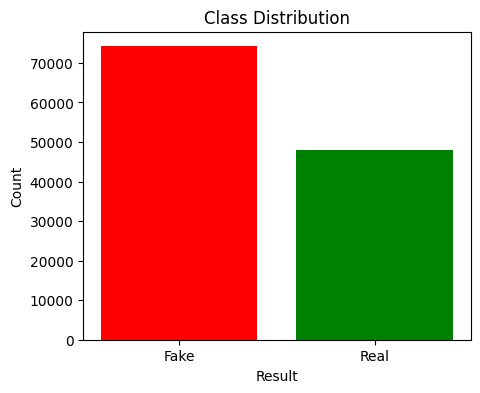

In [ ]:
# Count the number of instances in each class
class_counts = merged_text_img_data['2_way_label'].value_counts()

# Plot the class distribution
beingsaved = plt.figure(figsize=(5, 4))
colors = ['red', 'green']
plt.bar(['Fake', 'Real'], class_counts.values, color=colors)
plt.xlabel('Result')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
merged_text_img_data.isna().sum()

clean_title                 0
domain                  36463
hasImage                    0
id                          0
linked_submission_id    85755
num_comments            36463
score                       0
subreddit                   0
title                       0
upvote_ratio            36463
2_way_label                 0
3_way_label                 0
6_way_label                 0
Image_Path                  0
dtype: int64

In [ ]:
!pip install transformers

In [ ]:
pip uninstall -y transformers

Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2


In [ ]:
import tensorflow as tf
# from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import DistilBertTokenizerFast
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
# from transformers import DistilBertTokenizer, TFDistilBertModel, ViTFeatureExtractor, TFViTModel,ViTImageProcessor
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model

In [9]:
sub_text_img = merged_text_img_data.head(1000)
sub_text_img

,clean_title,domain,hasImage,id,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,Image_Path
0,my walgreens offbrand mucinex was engraved wit...,i.imgur.com,True,awxhir,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...
1,puppy taking in the view,i.imgur.com,True,4xypkv,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...
2,i found a face in my sheet music too,i.redd.it,True,8gnet9,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2,/content/gdrive/My Drive/Nalinika/train_images...
3,major thermos,i.redd.it,True,6d50rl,NaN,0.0,2,pareidolia,major thermos,0.67,0,2,2,/content/gdrive/My Drive/Nalinika/train_images...
4,cutest baby cow ive seen in my head all day an...,i.redd.it,True,796d3z,NaN,21.0,141,subredditsimulator,Cutest baby cow I've seen in my head all day a...,0.99,0,2,3,/content/gdrive/My Drive/Nalinika/train_images...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,i was looking at a torpedo when i saw this loo...,i.redd.it,True,d322dd,NaN,0.0,16,pareidolia,I was looking at a torpedo when I saw this loo...,0.86,0,2,2,/content/gdrive/My Drive/Nalinika/train_images...
996,report at least people hanged in syrian prison...,bigstory.ap.org,True,5si5d9,NaN,1.0,23,neutralnews,"Report: At least 13,000 people hanged in Syria...",0.94,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...
997,jimmy carter and an aide vaulting a fence,i.redd.it,True,6n9jy8,NaN,3.0,4,photoshopbattles,PsBattle: Jimmy Carter and an aide vaulting a ...,0.75,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...
998,after initial tests in us facebook rolls out a...,techcrunch.com,True,7fwg79,NaN,4.0,49,upliftingnews,"After initial tests in US, Facebook rolls out ...",0.85,1,0,0,/content/gdrive/My Drive/Nalinika/train_images...


In [10]:
sub_text_img.loc[:, 'Image_Path'] = sub_text_img['Image_Path'] + os.sep + sub_text_img['id'] + ".jpg"
sub_text_img['Image_Path'][1]

'/content/gdrive/My Drive/Nalinika/train_images2/set 12/4xypkv.jpg'

In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sub_text_img, test_size=0.20)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

train shape:  (800, 14)
test shape:  (200, 14)


In [12]:
import gc

del sub_text_img
del merged_text_img_data
del image_paths_df
del img_txt_data_df
gc.collect()

43

# CLIP based Model

In [13]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nk06hxaz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nk06hxaz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [14]:
import clip
from PIL import Image
import torch
import torch.nn as nn
import cv2
from torch.utils.data import Dataset, DataLoader

In [ ]:
import clip
from PIL import Image
import torch
import torch.nn as nn
import cv2
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, images, labels, preprocess):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        image = self.preprocess(image).unsqueeze(0).to(device)
        text = clip.tokenize(self.texts[idx])
        label = self.labels[idx]
        # image = torch.tensor(image).permute(2, 0, 1).float()
        return text, image, label

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, clip_model):
        super(CombinedModel, self).__init__()
        self.clip_model = clip_model
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, image, text):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)
        combined_features = torch.cat((image_features, text_features), dim=1)

        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [ ]:
texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

dataset = FakeNewsDataset(texts, images, labels, preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model
combined_model = CombinedModel(model).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):  # Number of epochs

    for texts, images, labels in dataloader:

        images = images.squeeze(1).to(device)
        texts = texts.squeeze(1).to(device)  # Remove the batch dimension from text inputs
        labels = labels.to(device).float()

        # Forward pass
        outputs = combined_model(images, texts).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6550
Epoch [2/10], Loss: 0.5318
Epoch [3/10], Loss: 0.2847
Epoch [4/10], Loss: 0.2649
Epoch [5/10], Loss: 0.1784
Epoch [6/10], Loss: 0.1567
Epoch [7/10], Loss: 0.1334
Epoch [8/10], Loss: 0.0736
Epoch [9/10], Loss: 0.0813
Epoch [10/10], Loss: 0.0459


In [ ]:
# Evaluate the model
def evaluate(model, dataloader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for texts, images, labels in dataloader:

            images = images.squeeze(1).to(device)
            texts = texts.squeeze(1).to(device)
            labels = labels.to(device).float()
            outputs = model(images, texts).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

texts = test_df['title'].values
images = test_df['Image_Path'].values
labels = test_df['2_way_label'].values

# Assuming you have a test dataloader
dataset = FakeNewsDataset(texts, images, labels, preprocess)
print(test_df.shape)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

evaluate(combined_model, test_dataloader)

(200, 14)
Accuracy: 87.00%


In [ ]:
class ClipBasedModel(nn.Module):
    def __init__(self, clip_model, hidden_dim):
        super(ClipBasedModel, self).__init__()
        self.clip_model = clip_model
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, image, text):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)
        combined_features = torch.cat((image_features, text_features), dim=1)

        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


**Hyper-parameter Tunning**

In [ ]:

param_grid = {
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [8, 16],
    'hidden_dim': [1024]
}


texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess)

best_accuracy = 0
best_params = None

for lr, batch_size, hidden_dim in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    clip_Model = ClipBasedModel(model, hidden_dim).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(clip_Model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = clip_Model(image_inputs,text_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels in val_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = clip_Model(image_inputs,text_inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'hidden_dim': hidden_dim}

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


Best Accuracy: 0.895
Best Params: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_dim': 1024}


## Decision Level Fusion

In [ ]:
def custom_collate_fn(batch):
    # Unpack the batch
    inputs, labels = zip(*batch)

    # Process inputs
    text_input_ids = pad_sequence([x['input_ids'].squeeze(0) for x in inputs], batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    text_attention_mask = pad_sequence([x['attention_mask'].squeeze(0) for x in inputs], batch_first=True, padding_value=0)
    image_pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in inputs])

    text_batch = {
        'input_ids': text_input_ids,
        'attention_mask': text_attention_mask
    }
    image_batch = {
        'pixel_values': image_pixel_values
    }

    # Process labels
    labels = torch.tensor(labels)

    return text_batch, image_batch, labels


In [ ]:
class MultimodalDecisionLevelFusionModel(nn.Module):
    def __init__(self, clip_model, hidden_dim):
        super(MultimodalDecisionLevelFusionModel, self).__init__()
        self.clip_model = clip_model
        self.fc_text = nn.Linear(clip_model.text_projection.shape[0], hidden_dim)
        self.fc_image = nn.Linear(clip_model.visual.output_dim, hidden_dim)
        self.fc_combined = nn.Linear(hidden_dim * 2, 256)
        self.fc_final = nn.Linear(256, 1)


    def forward(self, image, text):
        with torch.no_grad():
            text_embeddings = self.clip_model.encode_image(image)
            image_embeddings = self.clip_model.encode_text(text)

        text_features = torch.relu(self.fc_text(text_embeddings.float()))
        image_features = torch.relu(self.fc_image(image_embeddings.float()))

        combined_features = torch.cat((text_features, image_features), dim=1)

        x = torch.relu(self.fc_combined(combined_features))
        x = torch.sigmoid(self.fc_final(x))

        return x


In [ ]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [ 1e-3, 1e-4, 1e-5],
    'batch_size': [32, 64],
    'hidden_dim': [512]
}


texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess)

best_accuracy = 0
best_params = None

for lr, batch_size, hidden_dim in product(*param_grid.values()):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    late_fusion_clip_Model = MultimodalDecisionLevelFusionModel(model, hidden_dim).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

   # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = late_fusion_clip_Model(image_inputs,text_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels in val_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = late_fusion_clip_Model(image_inputs,text_inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'hidden_dim': hidden_dim}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")



Accuracy: 0.57
Best Params: {'learning_rate': 1e-05, 'batch_size': 64, 'hidden_dim': 512}


In [ ]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [ 1e-3, 1e-4, 1e-5],
    'batch_size': [32, 64],
    'hidden_dim': [512]
}


texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess)

best_accuracy = 0
best_params = None

for lr, batch_size, hidden_dim in product(*param_grid.values()):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    late_fusion_clip_Model = MultimodalDecisionLevelFusionModel(model, hidden_dim).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

   # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = late_fusion_clip_Model(image_inputs,text_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels in val_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = late_fusion_clip_Model(image_inputs,text_inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'hidden_dim': hidden_dim}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")



# T5 based Model with ViT Model

### Concat Fusion Method

In [15]:
import pandas as pd
import numpy as np
import torch
from transformers import T5Tokenizer, T5EncoderModel, ViTFeatureExtractor, ViTModel
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, image_paths, labels, text_tokenizer, image_processor):
        self.texts = texts
        self.image_paths = image_paths
        self.labels = labels
        self.text_tokenizer = text_tokenizer
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Process text
        text = self.texts[idx]
        text_inputs = self.text_tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Process image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image_inputs = self.image_processor(images=image, return_tensors="pt")

        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return text_inputs, image_inputs, label


In [ ]:
def custom_collate_fn(batch):
    # Unpack the batch
    text_inputs, image_inputs, labels = zip(*batch)

    # Process text inputs
    input_ids = torch.nn.utils.rnn.pad_sequence([x['input_ids'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=text_tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence([x['attention_mask'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=0)
    text_batch = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    # Process image inputs
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in image_inputs])
    image_batch = {
        'pixel_values': pixel_values
    }

    # Process labels
    labels = torch.tensor(labels)

    return text_batch, image_batch, labels


In [ ]:
# Example data
texts = train_df['title'].values
image_paths = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

# Initialize the tokenizers and processors
text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Create dataset and dataloader
dataset = CustomDataset(texts, image_paths, labels, text_tokenizer, image_processor)

# def collate_fn(data):
#     zipped = zip(data)
#     return list(zipped)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc1 = nn.Linear(self.text_model.config.d_model + self.image_model.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings

        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
        x = torch.relu(self.fc1(combined_embeddings))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop
for epoch in range(5):  # Number of epochs
    model.train()
    for text_inputs, image_inputs, labels in dataloader:
        # Move to device

        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
        labels = labels.to(device)

        # Forward pass
        outputs = model(text_inputs, image_inputs).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.5856
Epoch [2/5], Loss: 0.3786
Epoch [3/5], Loss: 0.1837
Epoch [4/5], Loss: 0.2141
Epoch [5/5], Loss: 0.0054


In [ ]:
# Evaluate the model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for text_inputs, image_inputs, labels in dataloader:
            # Move to device
            text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            # Forward pass
            outputs = model(text_inputs, image_inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Assuming you have a test dataloader
# test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)
# evaluate(model, test_dataloader)
texts = test_df['title'].values
images = test_df['Image_Path'].values
labels = test_df['2_way_label'].values

# Assuming you have a test dataloader
dataset = CustomDataset(texts, images, labels, text_tokenizer, image_processor)

print(test_df.shape)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

evaluate(model, test_dataloader)

(200, 14)
Accuracy: 73.50%


### Hyper-parameter Tunning

In [ ]:
class T5ViTCombinedModel(nn.Module):
    def __init__(self):
        super(T5ViTCombinedModel, self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc1 = nn.Linear(self.text_model.config.d_model + self.image_model.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings

        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
        x = torch.relu(self.fc1(combined_embeddings))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [ ]:
param_grid = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'batch_size': [8, 16, 32]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = T5ViTCombinedModel().to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs, image_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels in val_loader:
            text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs,image_inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not in

Accuracy: 0.835
Best Params: {'learning_rate': 0.001, 'batch_size': 16}


### Late Fusion for T5 and ViT Model

In [ ]:
class LateFusionModel(nn.Module):
    def __init__(self, text_model, image_model, hidden_dim):
        super(LateFusionModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc_text = nn.Linear(self.text_model.config.d_model, hidden_dim)
        self.fc_image = nn.Linear(self.image_model.config.hidden_size, hidden_dim)
        self.fc_combined = nn.Linear(hidden_dim * 2, 256)
        self.fc_final = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings
        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation
        text_features = torch.relu(self.fc_text(text_embeddings))

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation
        image_features = torch.relu(self.fc_image(image_embeddings))

        # Combine embeddings using late fusion
        combined_features = torch.cat((text_features, image_features), dim=1)
        x = torch.relu(self.fc_combined(combined_features))
        x = torch.sigmoid(self.fc_final(x))
        return x



# class T5ViTCombinedModel(nn.Module):
#     def __init__(self):
#         super(T5ViTCombinedModel, self).__init__()
#         self.text_model = T5EncoderModel.from_pretrained('t5-small')
#         self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
#         self.fc1 = nn.Linear(self.text_model.config.d_model + self.image_model.config.hidden_size, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

#     def forward(self, text_inputs, image_inputs):
#         # Extract text embeddings

#         text_outputs = self.text_model(**text_inputs)
#         text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

#         # Extract image embeddings
#         image_outputs = self.image_model(**image_inputs)
#         image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

#         # Combine embeddings
#         combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
#         x = torch.relu(self.fc1(combined_embeddings))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# # Initialize the models
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# text_model = T5EncoderModel.from_pretrained('t5-small').to(device)
# image_model = ViTModel.from_pretrained('google/vit-base-patch16-224').to(device)

# # Initialize the late fusion model
#   # Example hidden dimension
# model = LateFusionModel(text_model, image_model, hidden_dim).to(device)


In [ ]:
param_grid = {
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [16, 32]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 512
text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

text_model = T5EncoderModel.from_pretrained('t5-small')
image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = LateFusionModel(text_model, image_model, hidden_dim).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs, image_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels in val_loader:
            text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs,image_inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.86
Best Params: {'learning_rate': 0.0001, 'batch_size': 16}


### MCB Pooling Layer Fusion

In [ ]:
"""
Multimodal Compact Bilinear Pooling (MCB from bellow)

[Reference] : "Multimodal Compact Bilinear Pooling for Visual Question Answering and Visual Grounding"
              (https://arxiv.org/abs/1606.01847)
"""

import numpy as np
import pickle

def mcb(features1, features2, d:int=512, save=False, filename="mcb_feature.pickle"):
    """
    tranform two vectors of samples to one, using MCB

    argument:
        - features1 : ndarray
            shape : (sample size, dimension)
            sample size must match features2
        - features2 : ndarray
            shape : (sample size, dimension)
            sample size must match features2
        - d : integer (default:16000)
            output dimension
        - save : bool (default:False)
            True : saves variable using pickle
        - filename : str (default:"mcb_feature.pickle")
            filename for saving the variable

    return:
        - mcb_features : ndarray
            shape : (sample size, d)
            feature vectors, extracted from two feature vectors with mcb
    """
    # sample size check
    if features1.shape[0] != features2.shape[0]:
        _raise_sample_size_exception()

    # count sketch
    h, s = _count_sketch_init([features1.shape[1], features2.shape[1]], d)

    sketch_features1 = []
    sketch_features2 = []

    for v0, v1 in zip(features1, features2):
        sketch_features1.append(_count_sketch(d, h[0], s[0], v0))
        sketch_features2.append(_count_sketch(d, h[1], s[1], v1))

    # fft
    fft_features1 = []
    fft_features2 = []

    for v0, v1 in zip(sketch_features1, sketch_features2):
        fft_features1.append(np.fft.fft(v0))
        fft_features2.append(np.fft.fft(v1))

    # element-wise product
    ewp_features = np.multiply(fft_features1, fft_features2)

    # ifft
    ifft_features = np.fft.ifft(ewp_features)

    # cast to float (only taking the real part from complex matrix)
    mcb_features = np.real(ifft_features)

    # TODO : add element-wise sqrt and l2 normalization

    if save:
        try:
            with open(filename, "wb") as fout:
                pickle.dump(mcb_features, fout)
        except Exception as e:
            raise e

    return mcb_features

def _count_sketch(d, h, s, v):
    """
    count sketch

    argument:
        - h : list
            shape : (dimension of v, )
            a list of integers between 0 to (d-1) that are randomly placed
       - s : list
            shape : (dimension of v, )
            a list of -1 or 1 that is randomly placed
        - v : array
            the vector you want to transform by count sketch

    return:
        - cs_vector : ndarray
            v transformed by count sketch
    """

    cs_vector = np.zeros(d).astype("float64")

    for dim_num, _ in enumerate(v):
        cs_vector[h[dim_num]] += s[dim_num] * v[dim_num]

    return cs_vector

def _count_sketch_init(feature_dims, d):
    """
    for variables used in count sketch

    argument:
        - feature_dims : list
            dimensions of features
        - d : int
            output dimension

    return:
        - h : list
            shape : (feature_dim, d)
            list of integer between 0 to (d-1), that are randomly chosen
        - s : list
            shape : (feature_dim, d)
            list of -1 or 1, that are randomly chosen
    """
    h = [None, None]
    s = [None, None]

    for vec_num in range(2): # NOTE: we are only thinking about two modalities
        h[vec_num] = np.random.randint(0, d-1, size=(feature_dims[vec_num], ))
        s[vec_num] = (np.floor(np.random.uniform(0, 2, size=(feature_dims[vec_num], ))) * 2 - 1).astype("int64")

    return h, s


# exceptions
class MCBException(Exception):
    """base class for mcb exceptions"""

class SampleSizeException(MCBException):
    """raise when sample size of two features does not match"""

def _raise_sample_size_exception():
    raise SampleSizeException("size of samples does not match")

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # self.mcb_pooling = CompactBilinearPooling(input_size, input_size, output_size).cuda()
        # self.flattened_tensor = nn.Flatten()
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)  # Assuming binary classification
        # self.double()

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings
        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings using MCB pooling
        combined_embeddings = mcb(text_embeddings, image_embeddings)
        # torch.cat((text_embeddings, image_embeddings), dim=1)

        # mcb(text_embeddings, image_embeddings)
        input = torch.from_numpy(combined_embeddings)
        # print(combined_embeddings.shape)
        # self.mcb_pooling(text_embeddings, image_embeddings)
        x = torch.relu(self.fc1(input.float()))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedModel()
# .to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop
for epoch in range(5):  # Number of epochs
    model.train()
    for text_inputs, image_inputs, labels in dataloader:
        # Move to device
        text_inputs = {k: v for k, v in text_inputs.items()}
        image_inputs = {k: v for k, v in image_inputs.items()}
        labels = labels

        # Forward pass
        outputs = model(text_inputs, image_inputs).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.9644
Epoch [2/5], Loss: 0.7357
Epoch [3/5], Loss: 0.7858
Epoch [4/5], Loss: 0.9122
Epoch [5/5], Loss: 0.7213


In [ ]:
# Evaluate the model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for text_inputs, image_inputs, labels in dataloader:
            # Move to device
            text_inputs = {k: v for k, v in text_inputs.items()}
            image_inputs = {k: v for k, v in image_inputs.items()}
            labels = labels

            # Forward pass
            outputs = model(text_inputs, image_inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Assuming you have a test dataloader
# test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)
# evaluate(model, test_dataloader)
texts = test_df['title'].values
images = test_df['Image_Path'].values
labels = test_df['2_way_label'].values

# Assuming you have a test dataloader
dataset = CustomDataset(texts, images, labels, text_tokenizer, image_processor)

print(test_df.shape)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

evaluate(model, test_dataloader)

(200, 14)
Accuracy: 56.50%


Hyper-parameter Tunning

In [ ]:
class MCBCombinedModel(nn.Module):
    def __init__(self,drop_out):
        super(MCBCombinedModel,self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # self.mcb_pooling = CompactBilinearPooling(input_size, input_size, output_size).cuda()
        # self.flattened_tensor = nn.Flatten()
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(drop_out)
        self.fc2 = nn.Linear(256, 1)  # Assuming binary classification
        # self.double()

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings
        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings using MCB pooling
        combined_embeddings = mcb(text_embeddings, image_embeddings)
        # torch.cat((text_embeddings, image_embeddings), dim=1)

        # mcb(text_embeddings, image_embeddings)
        input = torch.from_numpy(combined_embeddings)
        # print(combined_embeddings.shape)
        # self.mcb_pooling(text_embeddings, image_embeddings)
        x = torch.relu(self.fc1(input.float()))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CombinedModel()
# # .to(device)
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
param_grid = {
    'learning_rate': [1e-2, 1e-3],
    'batch_size': [16],
    'drop_out':[0.1, 0.2, 0.3]
}


text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size, drop_out in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = MCBCombinedModel(drop_out)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = {k: v for k, v in text_inputs.items()}
            image_inputs = {k: v for k, v in image_inputs.items()}
            labels = labels

            outputs = model(text_inputs, image_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels in val_loader:
            text_inputs = {k: v for k, v in text_inputs.items()}
            image_inputs = {k: v for k, v in image_inputs.items()}
            labels = labels

            outputs = model(text_inputs,image_inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size,'drop_out':drop_out}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Accuracy: 0.575
Best Params: {'learning_rate': 0.001, 'batch_size': 16, 'drop_out': 0.2}


# New Model

In [16]:
from transformers import BertTokenizer, BertConfig, BertModel, get_linear_schedule_with_warmup
import torch.nn.functional as F
from sklearn.metrics import classification_report
from transformers import AutoImageProcessor, ResNetModel

In [ ]:
class multimodal_attention(nn.Module):
    """
    dot-product attention mechanism
    """
    def __init__(self, attention_dropout=0.5):
        super(multimodal_attention, self).__init__()
        self.dropout = nn.Dropout(attention_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, scale=None, attn_mask=None):

        attention = torch.matmul(q, k.transpose(-2, -1))
        #print('attention.shape:{}'.format(attention.shape))
        if scale:
            attention = attention * scale


        # attention = attention.masked_fill_(attn_mask, -np.inf)
        attention = self.softmax(attention)
        #print('attention.shftmax:{}'.format(attention))
        attention = self.dropout(attention)
        attention = torch.matmul(attention, v)
        #print('attn_final.shape:{}'.format(attention.shape))

        return attention


class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim=256, num_heads=8, dropout=0.5):
        super(MultiHeadAttention, self).__init__()

        self.model_dim = model_dim
        self.dim_per_head = model_dim // num_heads
        self.num_heads = num_heads
        self.linear_k = nn.Linear(1, self.dim_per_head * num_heads, bias=False)
        self.linear_v = nn.Linear(1, self.dim_per_head * num_heads, bias=False)
        self.linear_q = nn.Linear(1, self.dim_per_head * num_heads, bias=False)

        self.dot_product_attention = multimodal_attention(dropout)
        self.linear_final = nn.Linear(model_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, query, key, value, attn_mask=None):
        residual = query
        query = query.unsqueeze(-1)
        key = key.unsqueeze(-1)
        value = value.unsqueeze(-1)
        #print("query.shape:{}".format(query.shape))

        dim_per_head = self.dim_per_head
        num_heads = self.num_heads
        #batch_size = key.size(0)

        # linear projection
        key = self.linear_k(key)
        value = self.linear_v(value)
        query = self.linear_q(query)
        #print('key.shape:{}'.format(key.shape))

        # split by heads
        key = key.view(-1, num_heads, self.model_dim, dim_per_head)
        value = value.view(-1, num_heads, self.model_dim, dim_per_head)
        query = query.view(-1, num_heads, self.model_dim, dim_per_head)

        # scaled dot product attention
        scale = (key.size(-1) // num_heads)**-0.5
        attention = self.dot_product_attention(query, key, value,
                                               scale, attn_mask)

        attention = attention.view(-1, self.model_dim, dim_per_head * num_heads)
        #print('attention_con_shape:{}'.format(attention.shape))

        # final linear projection
        output = self.linear_final(attention).squeeze(-1)
        #print('output.shape:{}'.format(output.shape))
        # dropout
        output = self.dropout(output)
        # add residual and norm layer
        output = self.layer_norm(residual + output)

        return output


class PositionalWiseFeedForward(nn.Module):
    """
    Fully-connected network
    """
    def __init__(self, model_dim=256, ffn_dim=2048, dropout=0.5):
        super(PositionalWiseFeedForward, self).__init__()
        self.w1 = nn.Linear(model_dim, ffn_dim)
        self.w2 = nn.Linear(ffn_dim, model_dim)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        residual = x

        x = self.w2(F.relu(self.w1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)
        output = x
        return output


class multimodal_fusion_layer(nn.Module):
    """
    A layer of fusing features
    """
    def __init__(self, model_dim=256, num_heads=8, ffn_dim=2048, dropout=0.5):
        super(multimodal_fusion_layer, self).__init__()
        self.attention_1 = MultiHeadAttention(model_dim, num_heads, dropout)
        self.attention_2 = MultiHeadAttention(model_dim, num_heads, dropout)

        self.feed_forward_1 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)
        self.feed_forward_2 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)

        self.fusion_linear = nn.Linear(model_dim*2, model_dim)

    def forward(self, image_output, text_output, attn_mask=None):

        output_1 = self.attention_1(image_output, text_output, text_output,
                                 attn_mask)

        output_2 = self.attention_2(text_output, image_output, image_output,
                                 attn_mask)


        #print('attention out_shape:{}'.format(output.shape))
        output_1 = self.feed_forward_1(output_1)
        output_2 = self.feed_forward_2(output_2)

        output = torch.cat([output_1, output_2], dim=1)
        output = self.fusion_linear(output)

        return output

### Model (Temp)

In [ ]:
class NetShareFusion(nn.Module):
    def __init__(self,model_dim,drop_and_BN, img_size=250,num_labels=2,num_layers=1,num_heads=8,ffn_dim=2048,dropout=0.5):

        super(NetShareFusion, self).__init__()

        self.CASED = 'google-bert/bert-base-uncased'
        self.model_dim = model_dim
        # self.pthfile = pthfile
        self.drop_and_BN = drop_and_BN

        #text
        self.config = BertConfig.from_pretrained(self.CASED)

        self.bert = BertModel.from_pretrained(self.CASED)
        self.linear_text = nn.Linear(768, model_dim)
        self.bn_text = nn.BatchNorm1d(model_dim)

        self.dropout = nn.Dropout(dropout)

        #image
        self.vgg = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # ResNetModel.from_pretrained("microsoft/resnet-50")
        #ViTModel.from_pretrained('google/vit-base-patch16-224')

        self.linear_image = nn.Linear(768, model_dim)
        self.bn_vgg = nn.BatchNorm1d(model_dim)

        #dct_image
        # self.dct_img = DctCNN(model_dim,
        #                       dropout,
        #                       kernel_sizes,
        #                       num_channels,
        #                       in_channel=128,
        #                       branch1_channels=[64],
        #                       branch2_channels=[48, 64],
        #                       branch3_channels=[64, 96, 96],
        #                       branch4_channels=[32],
        #                       out_channels=64)
        # self.linear_dct = nn.Linear(4096, model_dim)
        # self.bn_dct = nn.BatchNorm1d(model_dim)

        #multimodal fusion
        self.fusion_layers = nn.ModuleList([
            multimodal_fusion_layer(model_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])

        #classifier
        self.linear1 = nn.Linear(model_dim, 35)
        self.bn_1 = nn.BatchNorm1d(35)
        self.linear2 = nn.Linear(35, num_labels)
        self.softmax = nn.Softmax(dim=1)

    def drop_BN_layer(self, x, part='dct'):
        if part == 'dct':
            bn = self.bn_dct
        elif part == 'vgg':
            bn = self.bn_vgg
        elif part == 'bert':
            bn = self.bn_text

        if self.drop_and_BN == 'drop-BN':
            x = self.dropout(x)
            x = bn(x)
        elif self.drop_and_BN == 'BN-drop':
            x = bn(x)
            x = self.dropout(x)
        elif self.drop_and_BN == 'drop-only':
            x = self.dropout(x)
        elif self.drop_and_BN == 'BN-only':
            x = bn(x)
        elif self.drop_and_BN == 'none':
            pass

        return x

    def forward(self, text_input, image_input):

        #textual feature
        bert_output = self.bert(**text_input)
        text_output = bert_output[1]  #the representation of the whole sentence

        #print('bert_output:{}, shape:{}'.format(text_output, text_output.shape))
        # print(bert_output.last_hidden_state[:, 0, :].shape)

        text_output = F.relu(self.linear_text(bert_output.last_hidden_state[:, 0, :]))
        text_output = self.drop_BN_layer(text_output, part='bert')
#         print('text_output:{}'text_output.shape)

        #visual feature
        output = self.vgg(**image_input)
        # print(output.last_hidden_state[:, 0, :].shape)

        output = F.relu(self.linear_image(output.last_hidden_state[:, 0, :]))
        output = self.drop_BN_layer(output, part='vgg')

        # #dct_feature
        # dct_out = self.dct_img(dct_img)
        # dct_out = F.relu(self.linear_dct(dct_out))
        # dct_out = self.drop_BN_layer(dct_out, part='dct')


        # for fusion_layer in self.fusion_layers:
        #     output = fusion_layer(output, dct_out, attn_mask)

        for fusion_layer in self.fusion_layers:
            output = fusion_layer(output, text_output, text_input['attention_mask'])
            #print('fusion output_shape:{}'.format(output.shape))

        output = F.relu(self.linear1(output))
        output = self.dropout(output)
        #output = self.bn_1(output)
        output = self.linear2(output)
        #print('output_size:{}'.format(output.shape))
        y_pred_prob = self.softmax(output)

        return output, y_pred_prob


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, image_paths, labels, text_tokenizer, image_processor):
        self.texts = texts
        self.image_paths = image_paths
        self.labels = labels
        self.text_tokenizer = text_tokenizer
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Process text
        text = self.texts[idx]
        text_inputs = self.text_tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Process image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image_inputs = self.image_processor(images=image, return_tensors="pt")

        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return text_inputs, image_inputs, label


In [ ]:
def custom_collate_fn(batch):
    # Unpack the batch
    text_inputs, image_inputs, labels = zip(*batch)

    # Process text inputs
    input_ids = torch.nn.utils.rnn.pad_sequence([x['input_ids'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=text_tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence([x['attention_mask'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=0)
    text_batch = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    # Process image inputs
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in image_inputs])
    image_batch = {
        'pixel_values': pixel_values
    }

    # Process labels
    labels = torch.tensor(labels)

    return text_batch, image_batch, labels


### Training (Temp)

In [ ]:
def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1)
        labels_flat = labels
        return np.sum(pred_flat == labels_flat) / len(labels)

In [ ]:
param_grid = {
    'learning_rate': [1e-4],
    'batch_size': [8]
}

test_loss_values = []
acc_values, test_acc_values = [], []
test_precision_values = []
test_recall_values = []
test_f1_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# AutoImageProcessor.from_pretrained("microsoft/resnet-50")
#

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = NetShareFusion(768, 'none').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs, image_inputs)

            # loss_input = outputs[0]
            loss = criterion(outputs[0],  torch.tensor(labels,dtype=torch.long))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    test_batch_loss = []
    test_batch_acc = []
    report_label = []
    report_predict = []

    best_test_acc = 0

    for text_inputs, image_inputs, labels in val_loader:
        text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
        image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
        test_label = labels.to(device)

        with torch.no_grad():
            outputs = model(text_inputs,image_inputs)

        test_loss_input = outputs[0]
        test_loss = criterion(test_loss_input, torch.tensor(test_label,dtype=torch.long))

        predict = torch.max(outputs[1].cpu().detach(), 1)[1]

        test_pred_input = torch.sigmoid(outputs[1]).cpu().detach().numpy().tolist()  #output[1]
        test_label = test_label.cpu().detach().numpy().tolist()

        test_acc = flat_accuracy(test_pred_input, test_label)

        test_batch_loss.append(test_loss.detach().item())
        test_batch_acc.append(test_acc)

        for j in range(len(test_label)):
              report_label.append(test_label[j])
              report_predict.append(predict[j])

    test_epoch_loss = sum(test_batch_loss) / len(val_loader)
    test_epoch_acc = sum(test_batch_acc) / len(val_loader)
    report = classification_report(report_label, report_predict, output_dict = True)

    if test_epoch_acc > best_test_acc:
        best_test_acc = test_epoch_acc
        # self.condition_save(epoch_index, test_epoch_acc, report)

    test_loss_values.append(test_epoch_loss)
    test_acc_values.append(test_epoch_acc)
    test_precision_values.append(float(report["macro avg"]["precision"]))
    test_recall_values.append(float(report["macro avg"]["recall"]))
    test_f1_values.append(float(report["macro avg"]["f1-score"]))

    # val_predictions = np.array(val_predictions) > 0.5
    # accuracy = accuracy_score(val_targets, val_predictions)

    # if accuracy > best_accuracy:
    #     best_accuracy = accuracy
    #     best_params = {'learning_rate': lr, 'batch_size': batch_size}

best_accuracy = np.max(test_acc_values)
print(f"Accuracy: {best_accuracy}")
# print(f"Best Params: {best_params}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-9338bf81ab45>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs[0],  torch.tensor(labels,dtype=torch.long))
<ipython-input-21-9338bf81ab45>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss = criterion(test_loss_input, torch.tensor(test_label,dtype=torch.long))


Accuracy: 0.76


In [ ]:
param_grid = {
    'learning_rate': [1e-4, 1e-5],
    'batch_size': [8]
}

test_loss_values = []
acc_values, test_acc_values = [], []
test_precision_values = []
test_recall_values = []
test_f1_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# AutoImageProcessor.from_pretrained("microsoft/resnet-50")
#

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = NetShareFusion(768, 'none').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs, image_inputs)

            # loss_input = outputs[0]
            loss = criterion(outputs[0],  torch.tensor(labels,dtype=torch.long))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    test_batch_loss = []
    test_batch_acc = []
    report_label = []
    report_predict = []

    best_test_acc = 0

    for text_inputs, image_inputs, labels in val_loader:
        text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
        image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
        test_label = labels.to(device)

        with torch.no_grad():
            outputs = model(text_inputs,image_inputs)

        test_loss_input = outputs[0]
        test_loss = criterion(test_loss_input, torch.tensor(test_label,dtype=torch.long))

        predict = torch.max(outputs[1].cpu().detach(), 1)[1]

        test_pred_input = torch.sigmoid(outputs[1]).cpu().detach().numpy().tolist()  #output[1]
        test_label = test_label.cpu().detach().numpy().tolist()

        test_acc = flat_accuracy(test_pred_input, test_label)

        test_batch_loss.append(test_loss.detach().item())
        test_batch_acc.append(test_acc)

        for j in range(len(test_label)):
              report_label.append(test_label[j])
              report_predict.append(predict[j])

    test_epoch_loss = sum(test_batch_loss) / len(val_loader)
    test_epoch_acc = sum(test_batch_acc) / len(val_loader)
    report = classification_report(report_label, report_predict, output_dict = True)

    if test_epoch_acc > best_test_acc:
        best_test_acc = test_epoch_acc
        # self.condition_save(epoch_index, test_epoch_acc, report)

    test_loss_values.append(test_epoch_loss)
    test_acc_values.append(test_epoch_acc)
    test_precision_values.append(float(report["macro avg"]["precision"]))
    test_recall_values.append(float(report["macro avg"]["recall"]))
    test_f1_values.append(float(report["macro avg"]["f1-score"]))

    # val_predictions = np.array(val_predictions) > 0.5
    # accuracy = accuracy_score(val_targets, val_predictions)

    # if accuracy > best_accuracy:
    #     best_accuracy = accuracy
    #     best_params = {'learning_rate': lr, 'batch_size': batch_size}

best_accuracy = np.max(test_acc_values)
print(f"Accuracy: {best_accuracy}")
# print(f"Best Params: {best_params}")


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-9a0c7b9b6530>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs[0],  torch.tensor(labels,dtype=torch.long))
<ipython-input-22-9a0c7b9b6530>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Accuracy: 0.84


### Model 2 ( Temp )

In [ ]:
class NetShareFusion(nn.Module):
    def __init__(self,model_dim,drop_and_BN, img_size=250,num_labels=2,num_layers=1,num_heads=8,ffn_dim=2048,dropout=0.5):

        super(NetShareFusion, self).__init__()

        self.CASED = 'google-bert/bert-base-uncased'
        self.model_dim = model_dim
        # self.pthfile = pthfile
        self.drop_and_BN = drop_and_BN

        #text
        self.config = BertConfig.from_pretrained(self.CASED)

        self.bert = BertModel.from_pretrained(self.CASED)
        self.linear_text = nn.Linear(768, model_dim)
        self.bn_text = nn.BatchNorm1d(model_dim)

        self.dropout = nn.Dropout(dropout)

        #image
        self.vgg = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # ResNetModel.from_pretrained("microsoft/resnet-50")
        #ViTModel.from_pretrained('google/vit-base-patch16-224')

        self.linear_image = nn.Linear(768, model_dim)
        self.bn_vgg = nn.BatchNorm1d(model_dim)

        #multimodal fusion
        self.fusion_layers = nn.ModuleList([
            multimodal_fusion_layer(model_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])

        #classifier
        self.linear1 = nn.Linear(model_dim, 35)
        self.bn_1 = nn.BatchNorm1d(35)
        self.linear2 = nn.Linear(35, num_labels)
        self.softmax = nn.Softmax(dim=1)

    def drop_BN_layer(self, x, part='dct'):
        if part == 'dct':
            bn = self.bn_dct
        elif part == 'vgg':
            bn = self.bn_vgg
        elif part == 'bert':
            bn = self.bn_text

        if self.drop_and_BN == 'drop-BN':
            x = self.dropout(x)
            x = bn(x)
        elif self.drop_and_BN == 'BN-drop':
            x = bn(x)
            x = self.dropout(x)
        elif self.drop_and_BN == 'drop-only':
            x = self.dropout(x)
        elif self.drop_and_BN == 'BN-only':
            x = bn(x)
        elif self.drop_and_BN == 'none':
            pass

        return x

    def forward(self, text_input, image_input):

        #textual feature
        bert_output = self.bert(**text_input)
        text_output = bert_output[1]  #the representation of the whole sentence

        #print('bert_output:{}, shape:{}'.format(text_output, text_output.shape))
        # print(bert_output.last_hidden_state[:, 0, :].shape)

        text_output = F.relu(self.linear_text(bert_output.last_hidden_state[:, 0, :]))
        text_output = self.drop_BN_layer(text_output, part='bert')
#         print('text_output:{}'text_output.shape)

        #visual feature
        output = self.vgg(**image_input)
        # print(output.last_hidden_state[:, 0, :].shape)

        output = F.relu(self.linear_image(output.last_hidden_state[:, 0, :]))
        output = self.drop_BN_layer(output, part='vgg')

        # #dct_feature
        # dct_out = self.dct_img(dct_img)
        # dct_out = F.relu(self.linear_dct(dct_out))
        # dct_out = self.drop_BN_layer(dct_out, part='dct')


        # for fusion_layer in self.fusion_layers:
        #     output = fusion_layer(output, dct_out, attn_mask)

        for fusion_layer in self.fusion_layers:
            output = fusion_layer(output, text_output, text_input['attention_mask'])
            #print('fusion output_shape:{}'.format(output.shape))

        output = F.relu(self.linear1(output))
        output = self.dropout(output)
        #output = self.bn_1(output)
        output = self.linear2(output)
        #print('output_size:{}'.format(output.shape))
        y_pred_prob = self.softmax(output)

        return output, y_pred_prob


# BLIP Model

In [17]:
import clip
from PIL import Image
import torch
import torch.nn as nn
import cv2
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForImageTextRetrieval


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
# blip_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### dataset (Temp)

In [18]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, images, labels, preprocess, image_processor):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.preprocess = preprocess
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])

        preprocessed_image = self.preprocess(image).unsqueeze(0).to(device)
        text = clip.tokenize(self.texts[idx])
        label = self.labels[idx]

        encoding = self.image_processor(images=image, text=self.texts[idx], padding="max_length", return_tensors="pt")
        # remove batch dimension

        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # image = torch.tensor(image).permute(2, 0, 1).float()
        return text, preprocessed_image, label, encoding

In [19]:
class ClipAndBlipCombinedModel(nn.Module):
    def __init__(self, clip_model, blip_model):
        super(ClipAndBlipCombinedModel, self).__init__()
        self.clip_model = clip_model
        self.blip_model = blip_model
        self.fc1_clip = nn.Linear(1024, 512)
        self.fc2_clip = nn.Linear(512, 256)
        self.fc1_blip = nn.Linear(1024, 512)
        self.fc2_blip = nn.Linear(512, 256)
        self.fc3_clip = nn.Linear(256, 1)  # Assuming binary classification
        self.float()

    def forward(self, image, text, encodings):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)
        combined_features = torch.cat((image_features, text_features), dim=1)
        print("feature combined")
        x = torch.relu(self.fc1_clip(combined_features))
        x = torch.relu(self.fc2_clip(x))

        blip_outputs = self.blip_model(**encodings)
        print("blip output")
        # logits_per_image = blip_outputs.logits_per_image
        # probs = logits_per_image.softmax(dim=1)

        x_combined = torch.cat((x, blip_outputs.last_hidden_state[:, 0, :]), dim=1)
        print("all combined")
        x  = self.fc1_blip(x_combined)
        x = self.fc2_blip(x)
        x = F.relu(x)

        x = torch.sigmoid(self.fc3_clip(x))
        print(x)
        return x


### Train( Temp)

In [20]:

param_grid = {
    'learning_rate': [1e-3],
    'batch_size': [4]
}


texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess, processor)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess,processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    clip_Model = ClipAndBlipCombinedModel(model,blip_model).to(device)

    if torch.cuda.is_available():
      model.cuda()

    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(clip_Model.parameters(), lr=lr)

    # Training loop
    for epoch in range(2):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels, encoding in train_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = clip_Model(image_inputs,text_inputs,encoding)
            loss = criterion(outputs, labels.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            del text_inputs
            del image_inputs
            del encoding

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels,encoding in val_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = clip_Model(image_inputs,text_inputs,encoding).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


feature combined
blip output
all combined
tensor([[0.5289],
        [0.5180],
        [0.5251],
        [0.5351]], grad_fn=<SigmoidBackward0>)
feature combined
blip output
all combined
tensor([[0.4046],
        [0.4290],
        [0.4357],
        [0.4375]], grad_fn=<SigmoidBackward0>)
feature combined
blip output
all combined
tensor([[0.5171],
        [0.5147],
        [0.5161],
        [0.5136]], grad_fn=<SigmoidBackward0>)
feature combined
blip output
all combined
tensor([[0.5213],
        [0.5158],
        [0.5186],
        [0.5265]], grad_fn=<SigmoidBackward0>)
feature combined
blip output
all combined
tensor([[0.5098],
        [0.5104],
        [0.5102],
        [0.5125]], grad_fn=<SigmoidBackward0>)
feature combined
blip output
all combined
tensor([[0.4951],
        [0.5043],
        [0.4912],
        [0.5198]], grad_fn=<SigmoidBackward0>)
feature combined
blip output
all combined
tensor([[0.5117],
        [0.5175],
        [0.4718],
        [0.5053]], grad_fn=<SigmoidBackward0>)

In [124]:
import gc

del blip_model
del clip_Model
del image
del image_inputs
del images
gc.collect()

NameError: name 'image' is not defined

In [125]:
import gc

del labels
del text_inputs
del val_dataset
del val_loader

gc.collect()

8972

# BLIP Model 2

In [ ]:
from transformers import BlipProcessor, BlipForImageTextRetrieval


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
blip_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, images, labels, preprocess):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])

        encoding = self.preprocess(images=image, text=self.texts[idx], padding="max_length", return_tensors="pt")

        label = self.labels[idx]

        # remove batch dimension

        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # image = torch.tensor(image).permute(2, 0, 1).float()
        return encoding, label

In [ ]:
class BlipCombinedModel(nn.Module):
    def __init__(self, clip_model, blip_model):
        super(BlipCombinedModel, self).__init__()
        # self.clip_model = clip_model
        self.blip_model = blip_model
        self.fc1_blip = nn.Linear(blip_model., 512)
        self.fc2_blip = nn.Linear(512, 256)
        self.fc3_blip = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, image, text, encodings):
        with torch.no_grad():
            blip_outputs = self.blip_model(**encodings)

        x = torch.relu(self.fc1_clip(blip_outputs))
        x = torch.relu(self.fc2_clip(x))


        print("blip output")
        logits_per_image = X.logits_per_image
        probs = logits_per_image.softmax(dim=1)

        return probs


In [ ]:

param_grid = {
    'learning_rate': [1e-3],
    'batch_size': [8]
}


texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess, processor)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess,processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    clip_Model = BlipCombinedModel(blip_model).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(clip_Model.parameters(), lr=lr)

    # Training loop
    for epoch in range(2):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels, encoding in train_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = clip_Model(image_inputs,text_inputs,encoding)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            del text_inputs
            del image_inputs
            del encoding

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels,encoding in val_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = encoding

            outputs = clip_Model(image_inputs,text_inputs,encoding).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipModel

model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(
    text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
print(probs)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward0>)


In [ ]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForImageTextRetrieval

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco", torch_dtype=torch.bfloat16)

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

question = "A woman and a dog sitting together in a beach."
inputs = processor(raw_image, question, return_tensors="pt").to(torch.bfloat16)

itm_scores = model(**inputs)[0]
cosine_score = model(**inputs, use_itm_head=False)[0]
print(cosine_score)

tensor([[0.5234]], dtype=torch.bfloat16, grad_fn=<MmBackward0>)


In [36]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForImageTextRetrieval

model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")
processor = AutoProcessor.from_pretrained("Salesforce/blip-itm-base-coco")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "an image of a cat"

inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model(**inputs)
print(outputs)

BlipImageTextMatchingModelOutput(itm_score=tensor([[ 1.3384, -1.3361]], grad_fn=<AddmmBackward0>), loss=None, image_embeds=None, last_hidden_state=tensor([[[-0.3528,  0.5811, -0.6598,  ..., -0.8825,  0.3250, -0.3689],
         [ 0.5419,  0.3869,  0.8782,  ..., -0.9805,  0.0174,  0.1417],
         [ 0.4778,  0.0317,  0.1135,  ..., -0.1078, -0.5438, -0.2809],
         ...,
         [-0.0046,  0.2310, -0.1910,  ..., -0.5023, -0.1733,  0.1383],
         [ 0.3697,  0.3413,  0.3055,  ..., -0.9036,  0.1856,  0.1472],
         [-0.6902, -0.8056,  0.0778,  ...,  0.3903, -0.6928, -0.5706]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, vision_pooler_output=None, attentions=None, question_embeds=tensor([[[ 0.0127,  0.0605,  0.0130,  ...,  0.0077,  0.0368,  0.0203],
         [-0.0127,  0.0746,  0.0422,  ..., -0.0077,  0.0084,  0.0828],
         [-0.0502,  0.0830,  0.0398,  ..., -0.0079,  0.0216,  0.0415],
         ...,
         [ 0.0012,  0.0960,  0.0729,  ..., -0.0286,  0.0151,